# Echo State Networks

This is a notebook about the use of Echo State Networks (i.e., training it on some timeseries and perform predictions).

## Read in ERA5 Data

In [600]:
import xarray as xr
  
data = xr.open_dataset('C:/Users/Anwender/Documents/GitHub/RiVaPy_development/ERA5/dataset_2021-2023.nc')

In [601]:
data

<xarray.Dataset> Size: 2GB
Dimensions:    (longitude: 37, latitude: 33, expver: 2, time: 24897)
Coordinates:
  * longitude  (longitude) float32 148B 6.0 6.25 6.5 6.75 ... 14.5 14.75 15.0
  * latitude   (latitude) float32 132B 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * expver     (expver) int32 8B 1 5
  * time       (time) datetime64[ns] 199kB 2021-01-01 ... 2023-11-04T08:00:00
Data variables:
    u100       (time, expver, latitude, longitude) float64 486MB ...
    v100       (time, expver, latitude, longitude) float64 486MB ...
    u10        (time, expver, latitude, longitude) float64 486MB ...
    v10        (time, expver, latitude, longitude) float64 486MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-09 09:57:42 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [602]:
u_data = data['u100']
lon = data_u100['longitude']
lat = data_u100['latitude']
time = data_u100['time']

In [604]:
sel_lat = 20
sel_lon = 12
begin = -2*8760-9
end =  -2*8760-9+91*24
u = u_data[begin:end,0,:,:]
t = time[begin:end]

Text(0.5, 1.0, 'timeseries of u-wind at 100m height, lat =50;lon=9')

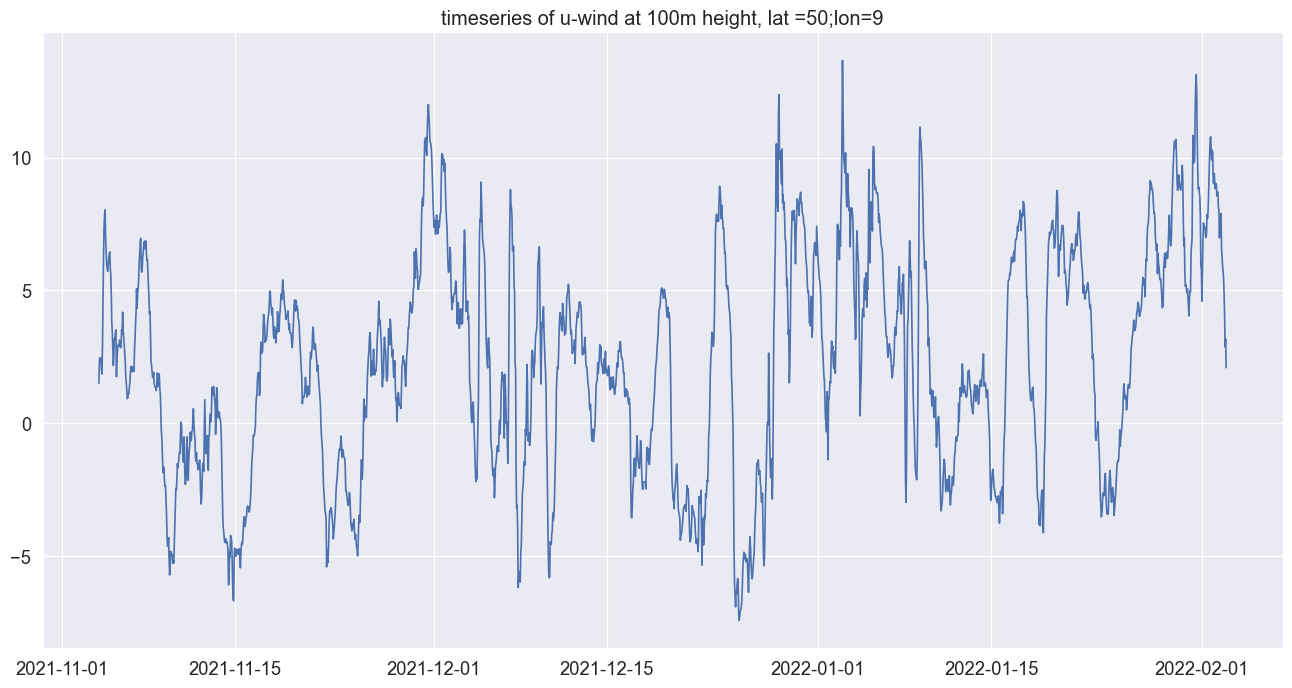

In [606]:
plt.figure(figsize=[16,8])
plt.plot(t,u[:,20,12])
plt.title('timeseries of u-wind at 100m height, lat =50;lon=9')

### PCA

In [610]:
from sklearn.decomposition import PCA

#nan_idx = np.argwhere(~np.isnan(u[:,0,0])).T[0] #11:-1545
#time_nan = time[nan_idx]
Y = np.array(u)
X = Y.reshape(Y.shape[0], -1)

In [613]:
pca = PCA(n_components=10)
X_red = pca.fit_transform(X) #shape (time, n_components)

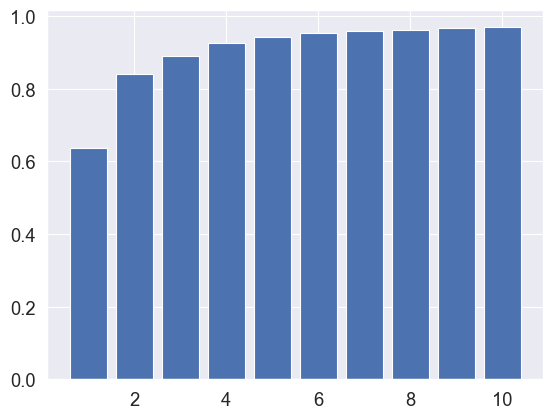

In [614]:
plt.figure()
plt.bar(np.linspace(1,pca.n_components_,pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.show()

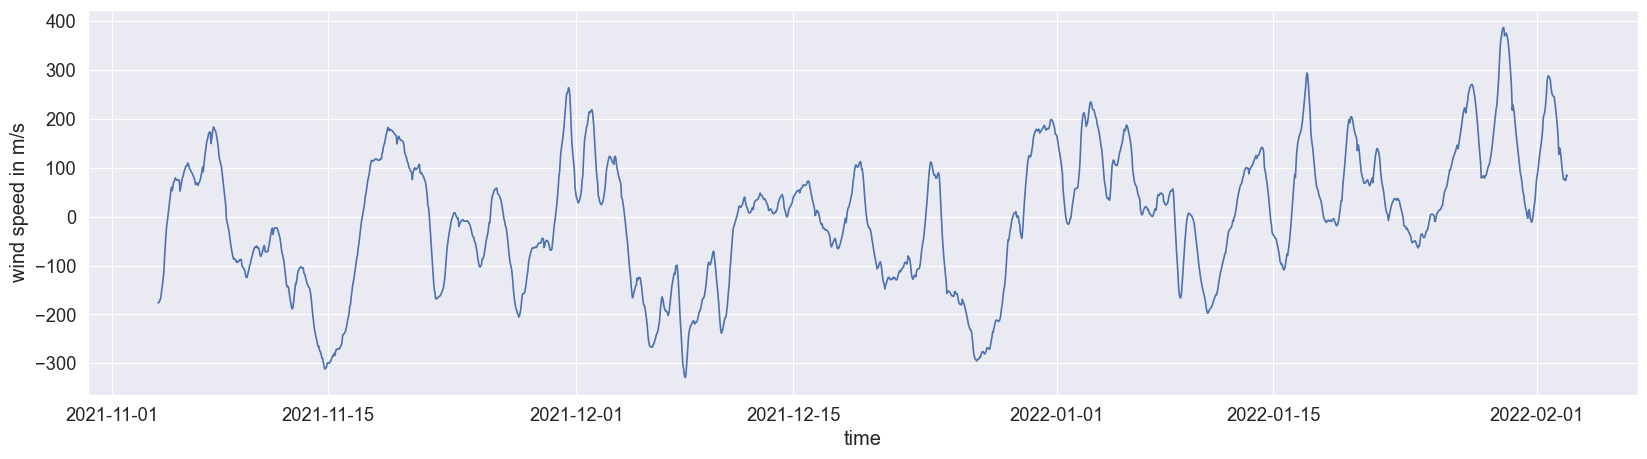

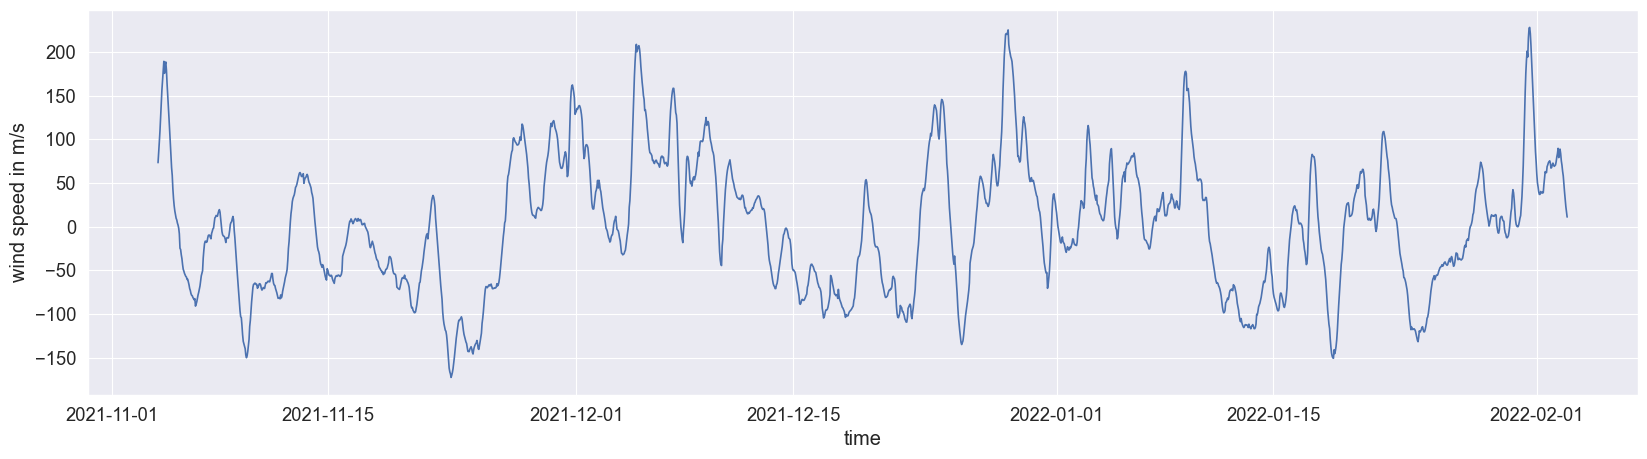

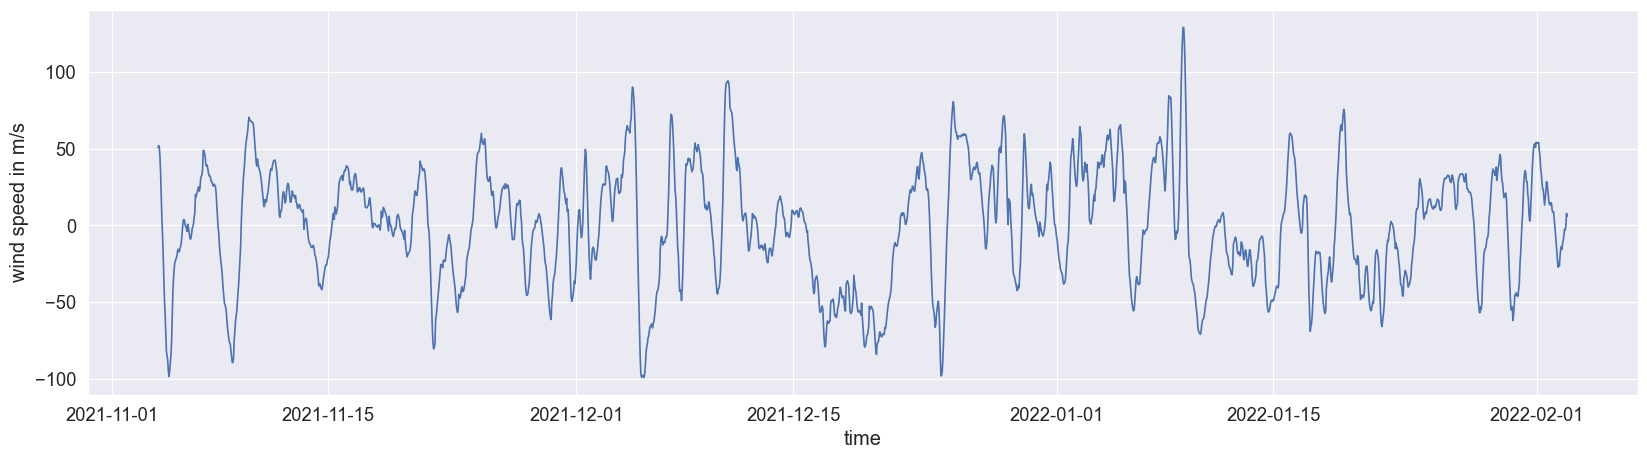

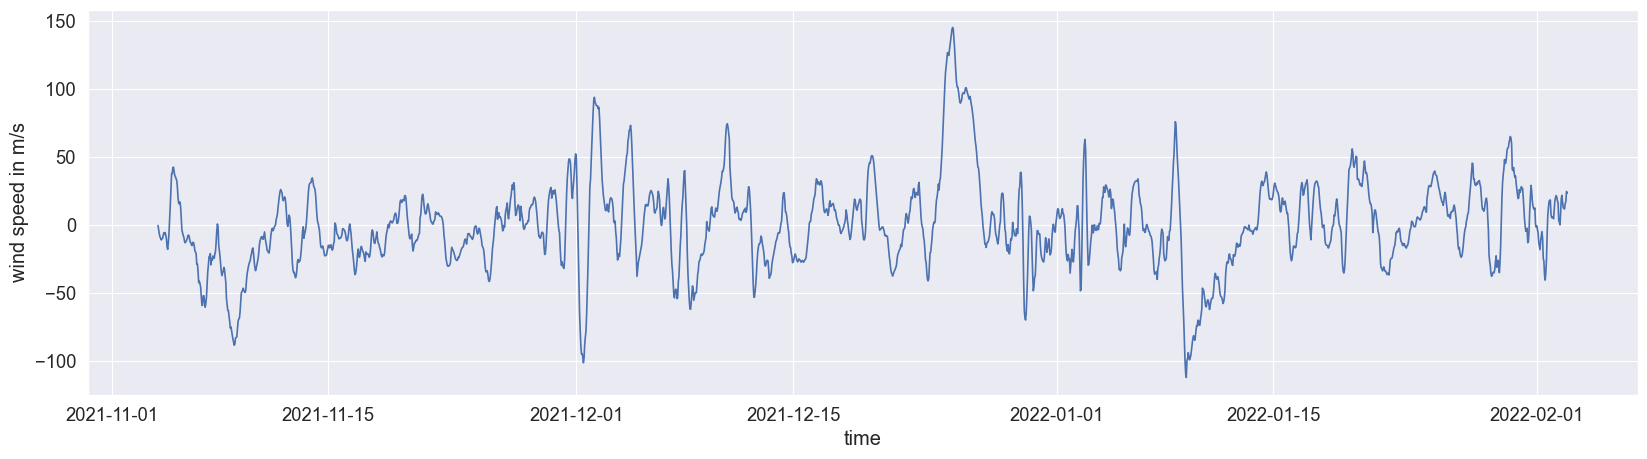

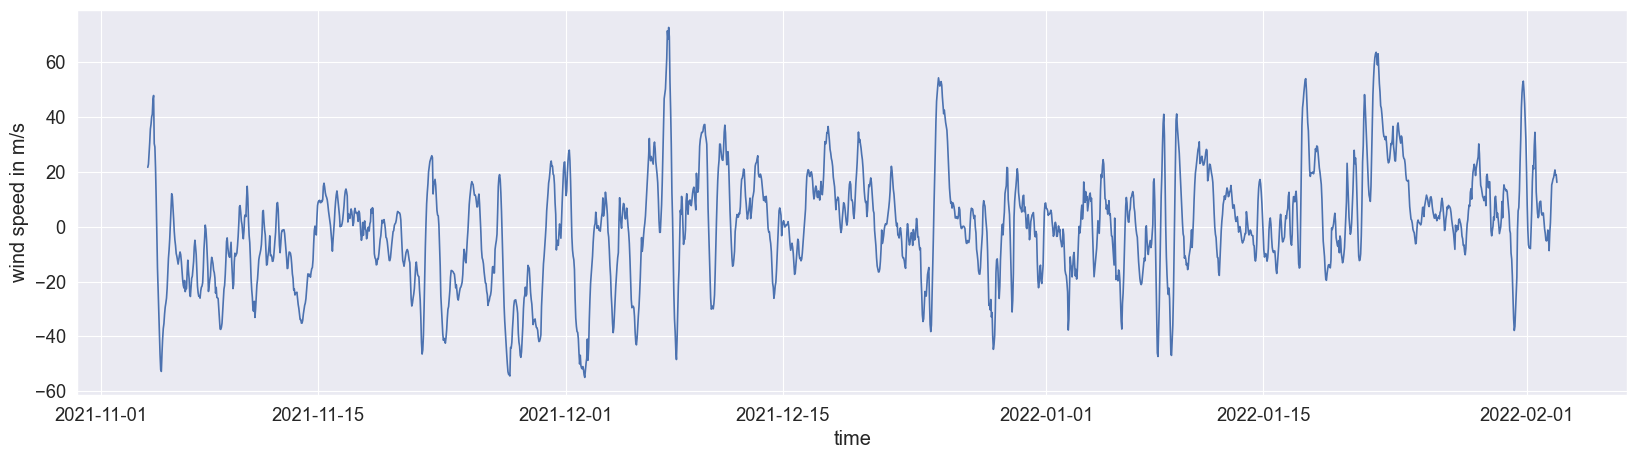

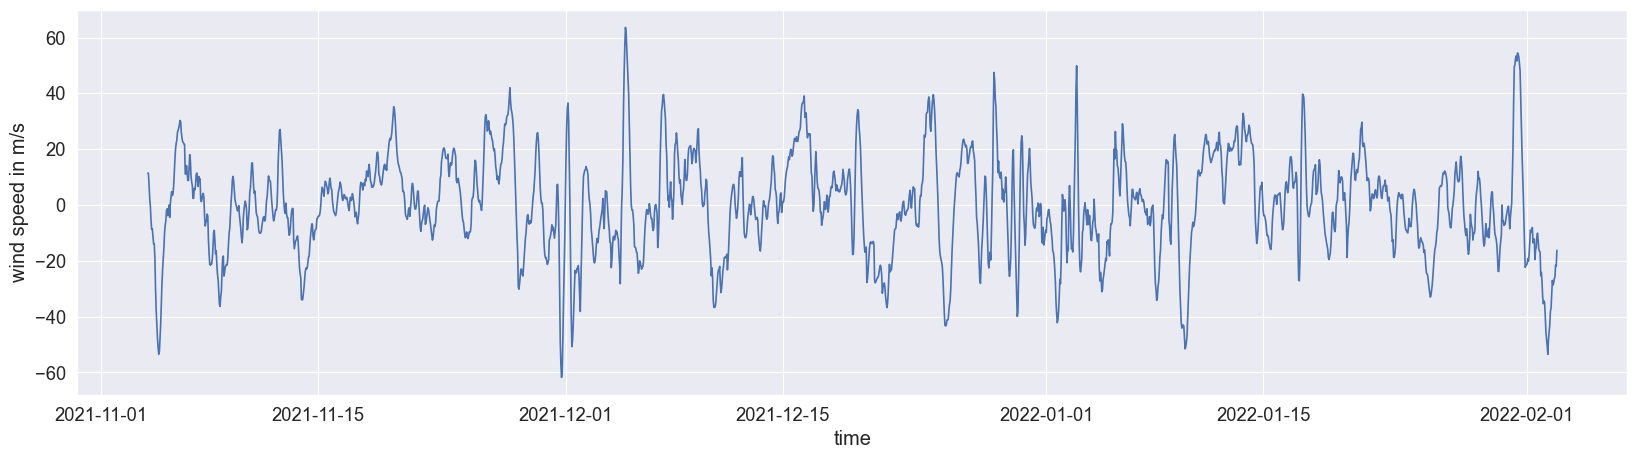

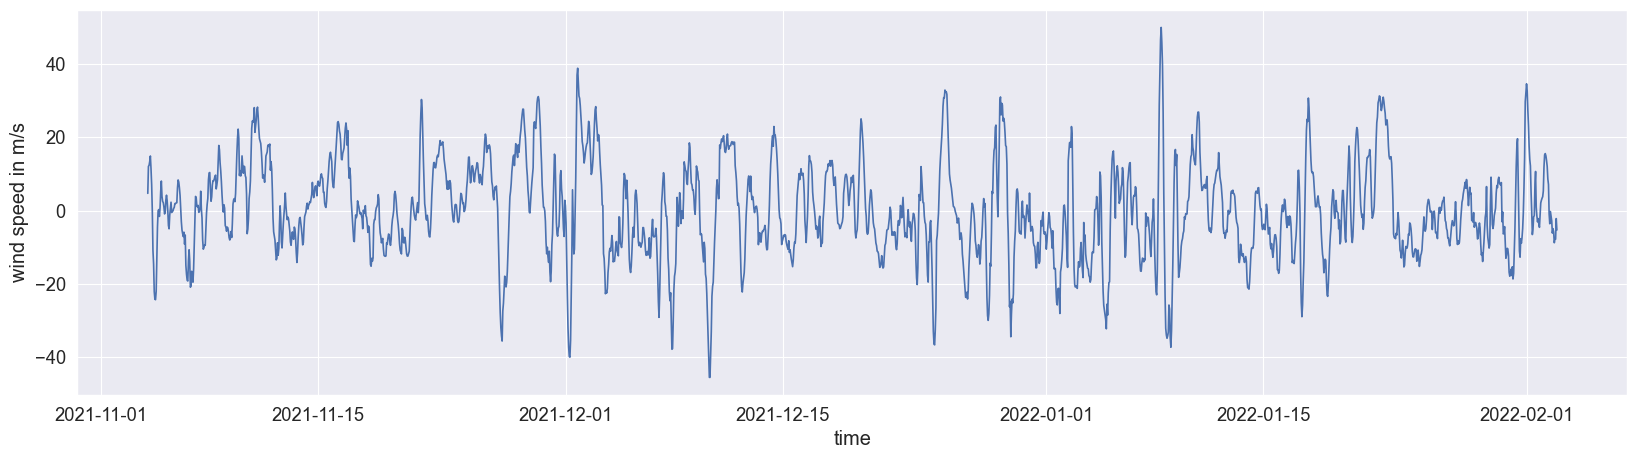

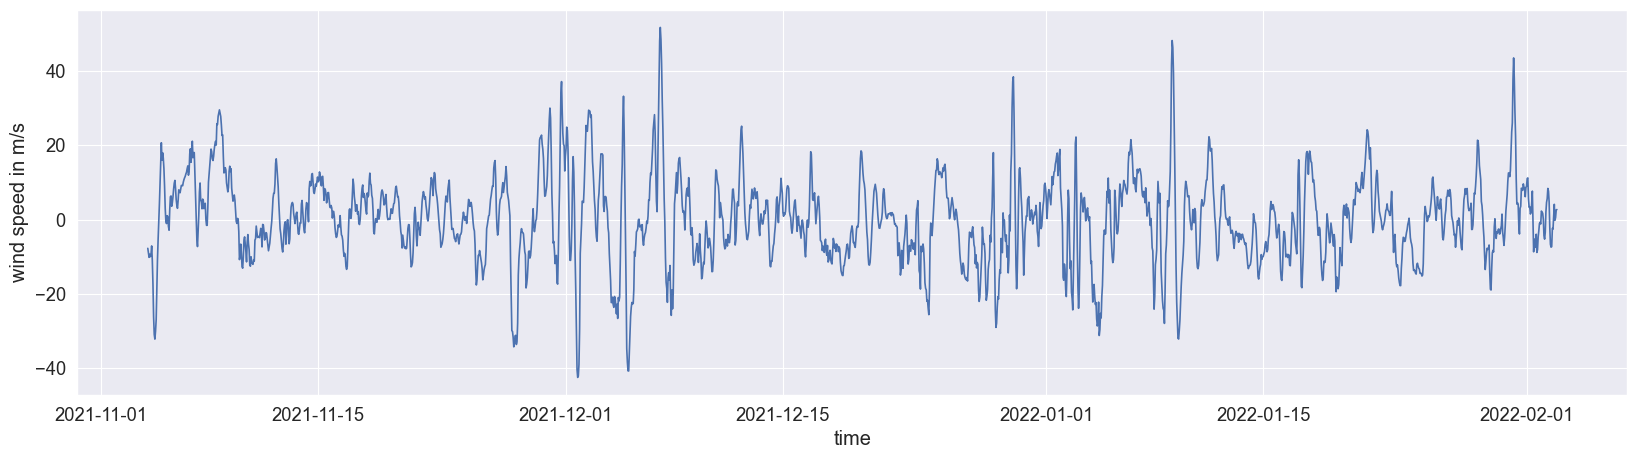

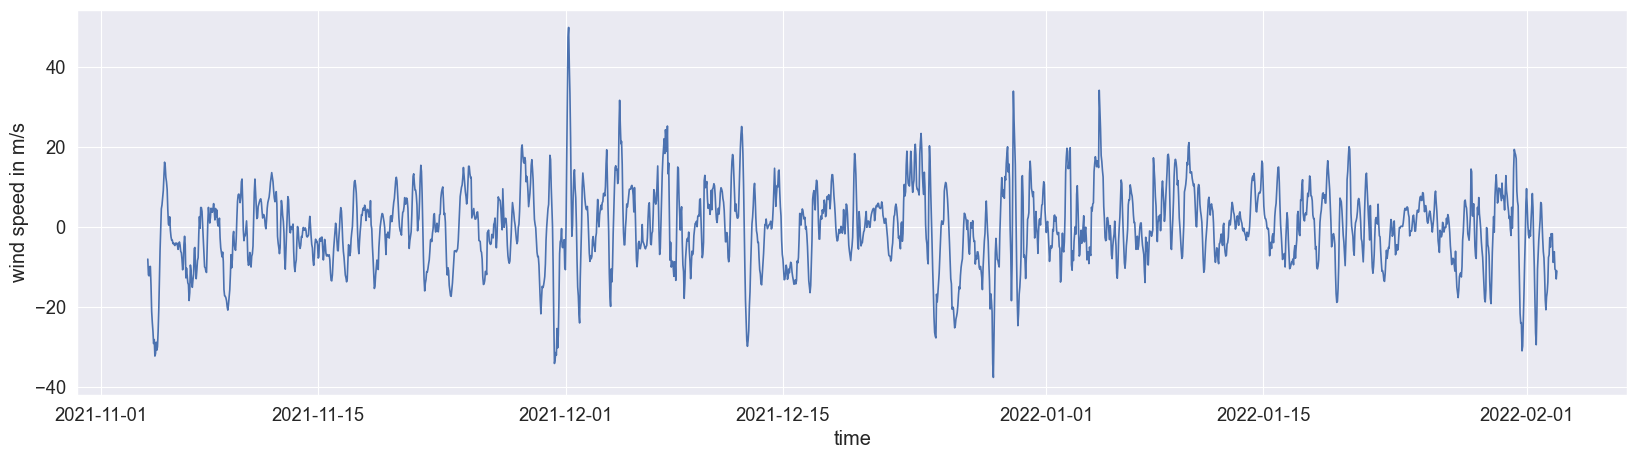

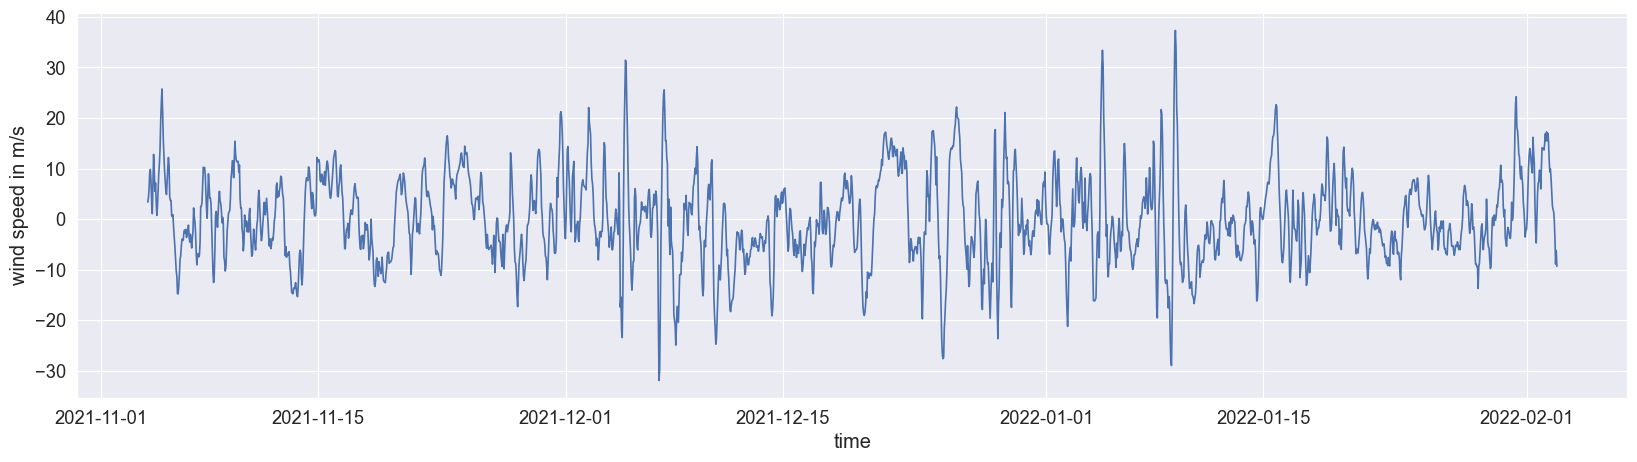

In [627]:
for loc0 in range(X_red.shape[1]):
    plt.figure(figsize=(20,5))
    plt.plot(t,X_red[:,loc0])
    plt.ylabel('wind speed in m/s')
    plt.xlabel('time')
    plt.show()

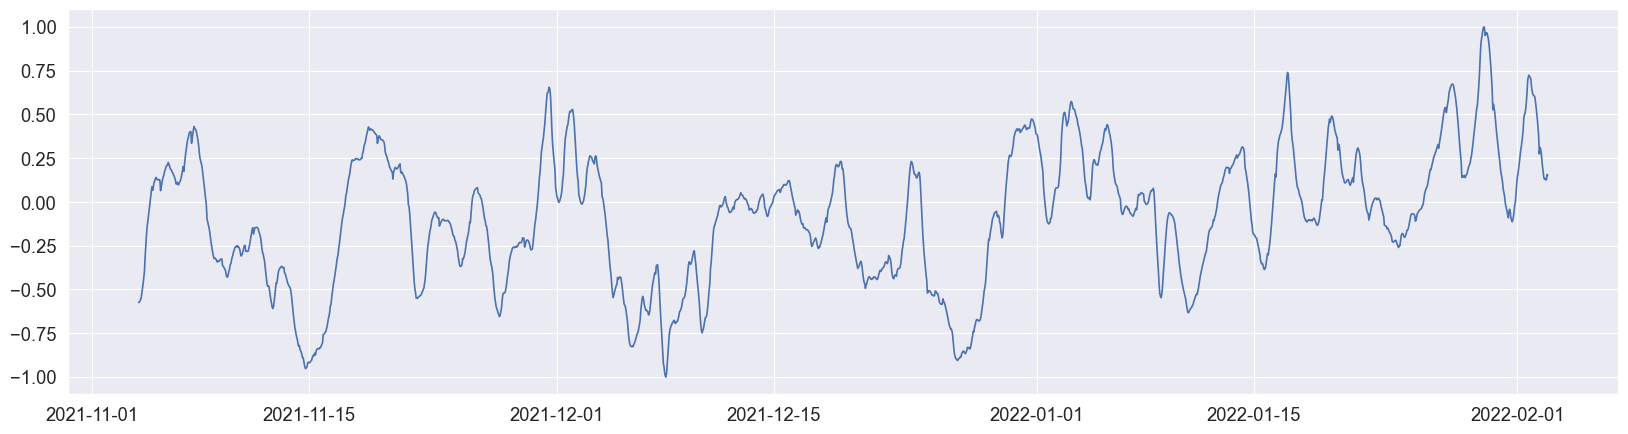

In [632]:

plt.figure(figsize=(20,5))
uu = X_red[:,0]
# rescale between -1 and 1
uu = 2 * (uu - uu.min()) / (uu.max() - uu.min()) - 1

plt.plot(t,uu)

## Task 1: 6 timesteps ahead forecast

In [633]:
def plot_train_test(X_train, y_train, X_test, y_test):
    sample = 500
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 500), X_train[-sample:], label="Training data")
    plt.plot(np.arange(0, 500), y_train[-sample:], label="Training ground truth")
    plt.plot(np.arange(500, 500+test_len), X_test, label="Testing data")
    plt.plot(np.arange(500, 500+test_len), y_test, label="Testing ground truth")
    plt.legend()
    plt.show()

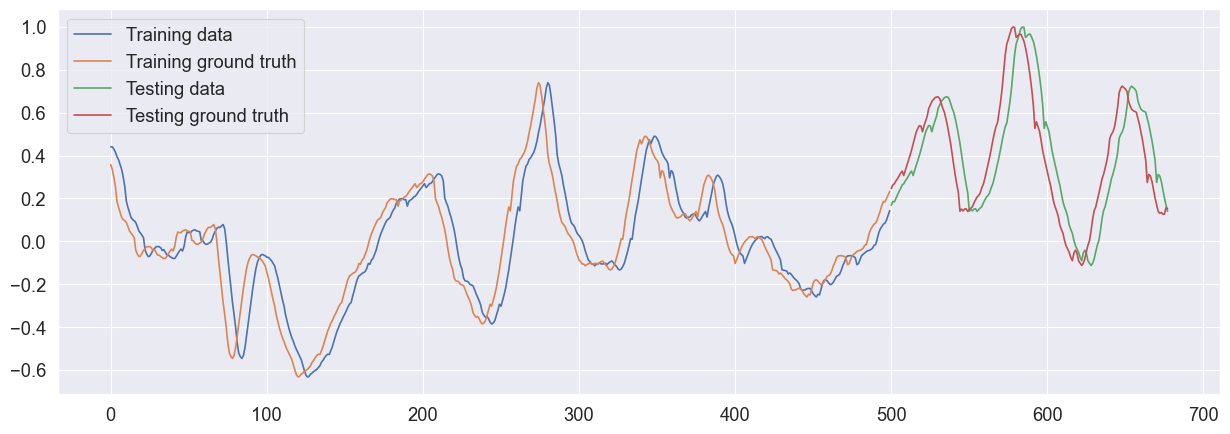

In [634]:
from reservoirpy.datasets import to_forecasting

X = np.array(uu).reshape(-1,1)
x, y = to_forecasting(X, forecast=6)
X_train1, y_train1 = x[:2000], y[:2000]
X_test1, y_test1 = x[2000:], y[2000:]

plot_train_test(X_train1, y_train1, X_test1, y_test1)

In [655]:
units = 100
leak_rate = 0.6752#0.3
spectral_radius =0.05#1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1.e-8
seed = 0#1234



In [656]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

In [657]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = Ridge(1, ridge=regularization)

esn = reservoir >> readout

In [658]:
y = esn(X[0])  # initialisation
reservoir.Win is not None, reservoir.W is not None, readout.Wout is not None

(True, True, True)

In [659]:
np.all(readout.Wout == 0.0)

True

In [660]:
esn = esn.fit(X_train1, y_train1)

In [661]:
def plot_readout(readout):
    Wout = readout.Wout
    bias = readout.bias
    Wout = np.r_[bias, Wout]

    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(111)
    ax.grid(axis="y")
    ax.set_ylabel("Coefs. of $W_{out}$")
    ax.set_xlabel("reservoir neurons index")
    ax.bar(np.arange(Wout.size), Wout.ravel()[::-1])

    plt.show()

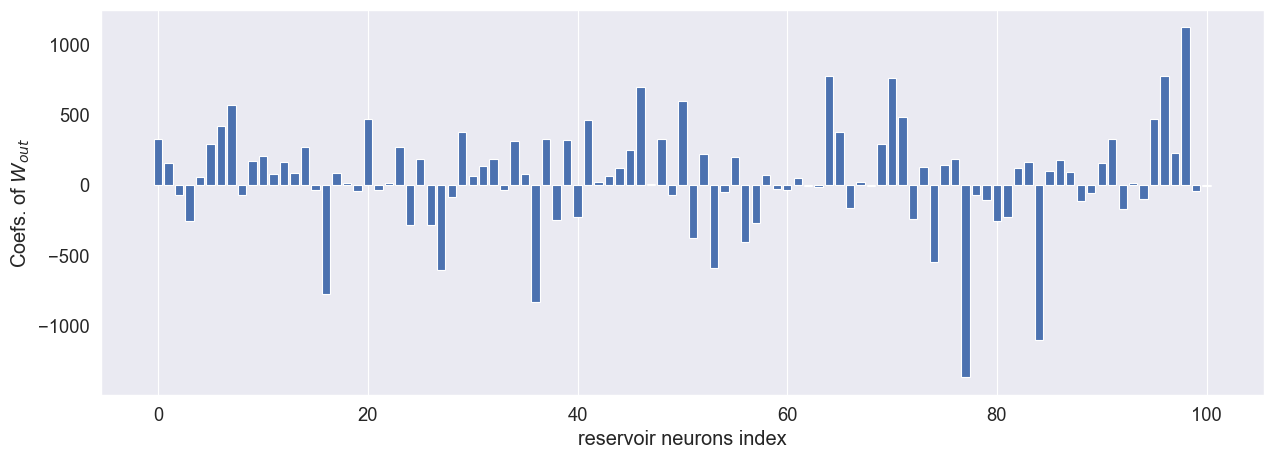

In [662]:
plot_readout(readout)

In [663]:
def plot_results(y_pred, y_test, sample=500):
    sample = 174
    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [664]:
y_pred1 = esn.run(X_test1)

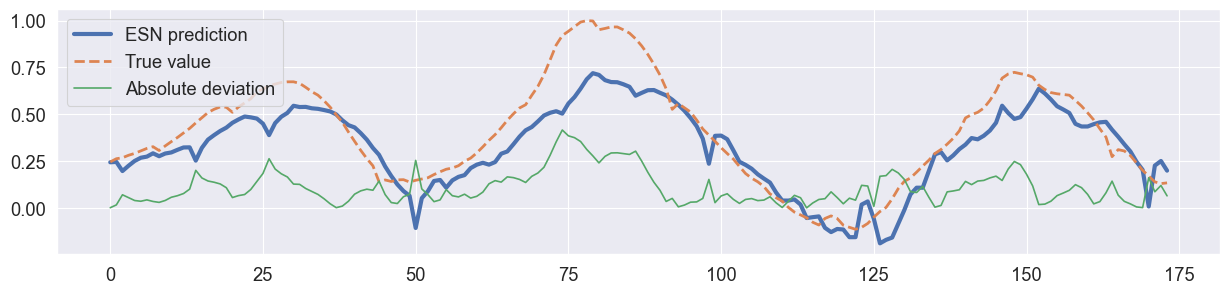

In [665]:
plot_results(y_pred1, y_test1)

### Hyperparameter Optimization

In [647]:
from reservoirpy.observables import nrmse, rsquare

In [649]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result of the loss function.
# You can add any additional metrics or information with other keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, y_train, x_test, y_test = dataset
    
    # You can access anything you put in the config file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances to be sure there is no bias in the results due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N, 
            sr=sr, 
            lr=lr, 
            input_scaling=input_scaling, 
            seed=variable_seed
        )

        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [650]:
import json

hyperopt_config = {
    "exp": "hyperopt-multiscroll",    # the experimentation name
    "hp_max_evals": 100,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-8, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [651]:
train_len = 1000
forecast = 2

X_train = X[:train_len]
Y_train = X[forecast : train_len + forecast]

X_test = X[train_len : -forecast]
Y_test = X[train_len + forecast:]

dataset = (X_train, Y_train, X_test, Y_test)

In [652]:
from reservoirpy.datasets import to_forecasting

X_train, X_test, Y_train, Y_test = to_forecasting(X, forecast=forecast, test_size=train_len-forecast)

In [653]:
from reservoirpy.hyper import research
best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 100/100 [08:28<00:00,  5.09s/trial, best loss: 0.026517425802546853]


In [654]:
best

({'N': 0,
  'input_scaling': 0,
  'lr': 0.6751854428024655,
  'ridge': 1.8829846044822546e-08,
  'seed': 0,
  'sr': 0.0501527653640703},
 <hyperopt.base.Trials at 0x2462c678410>)

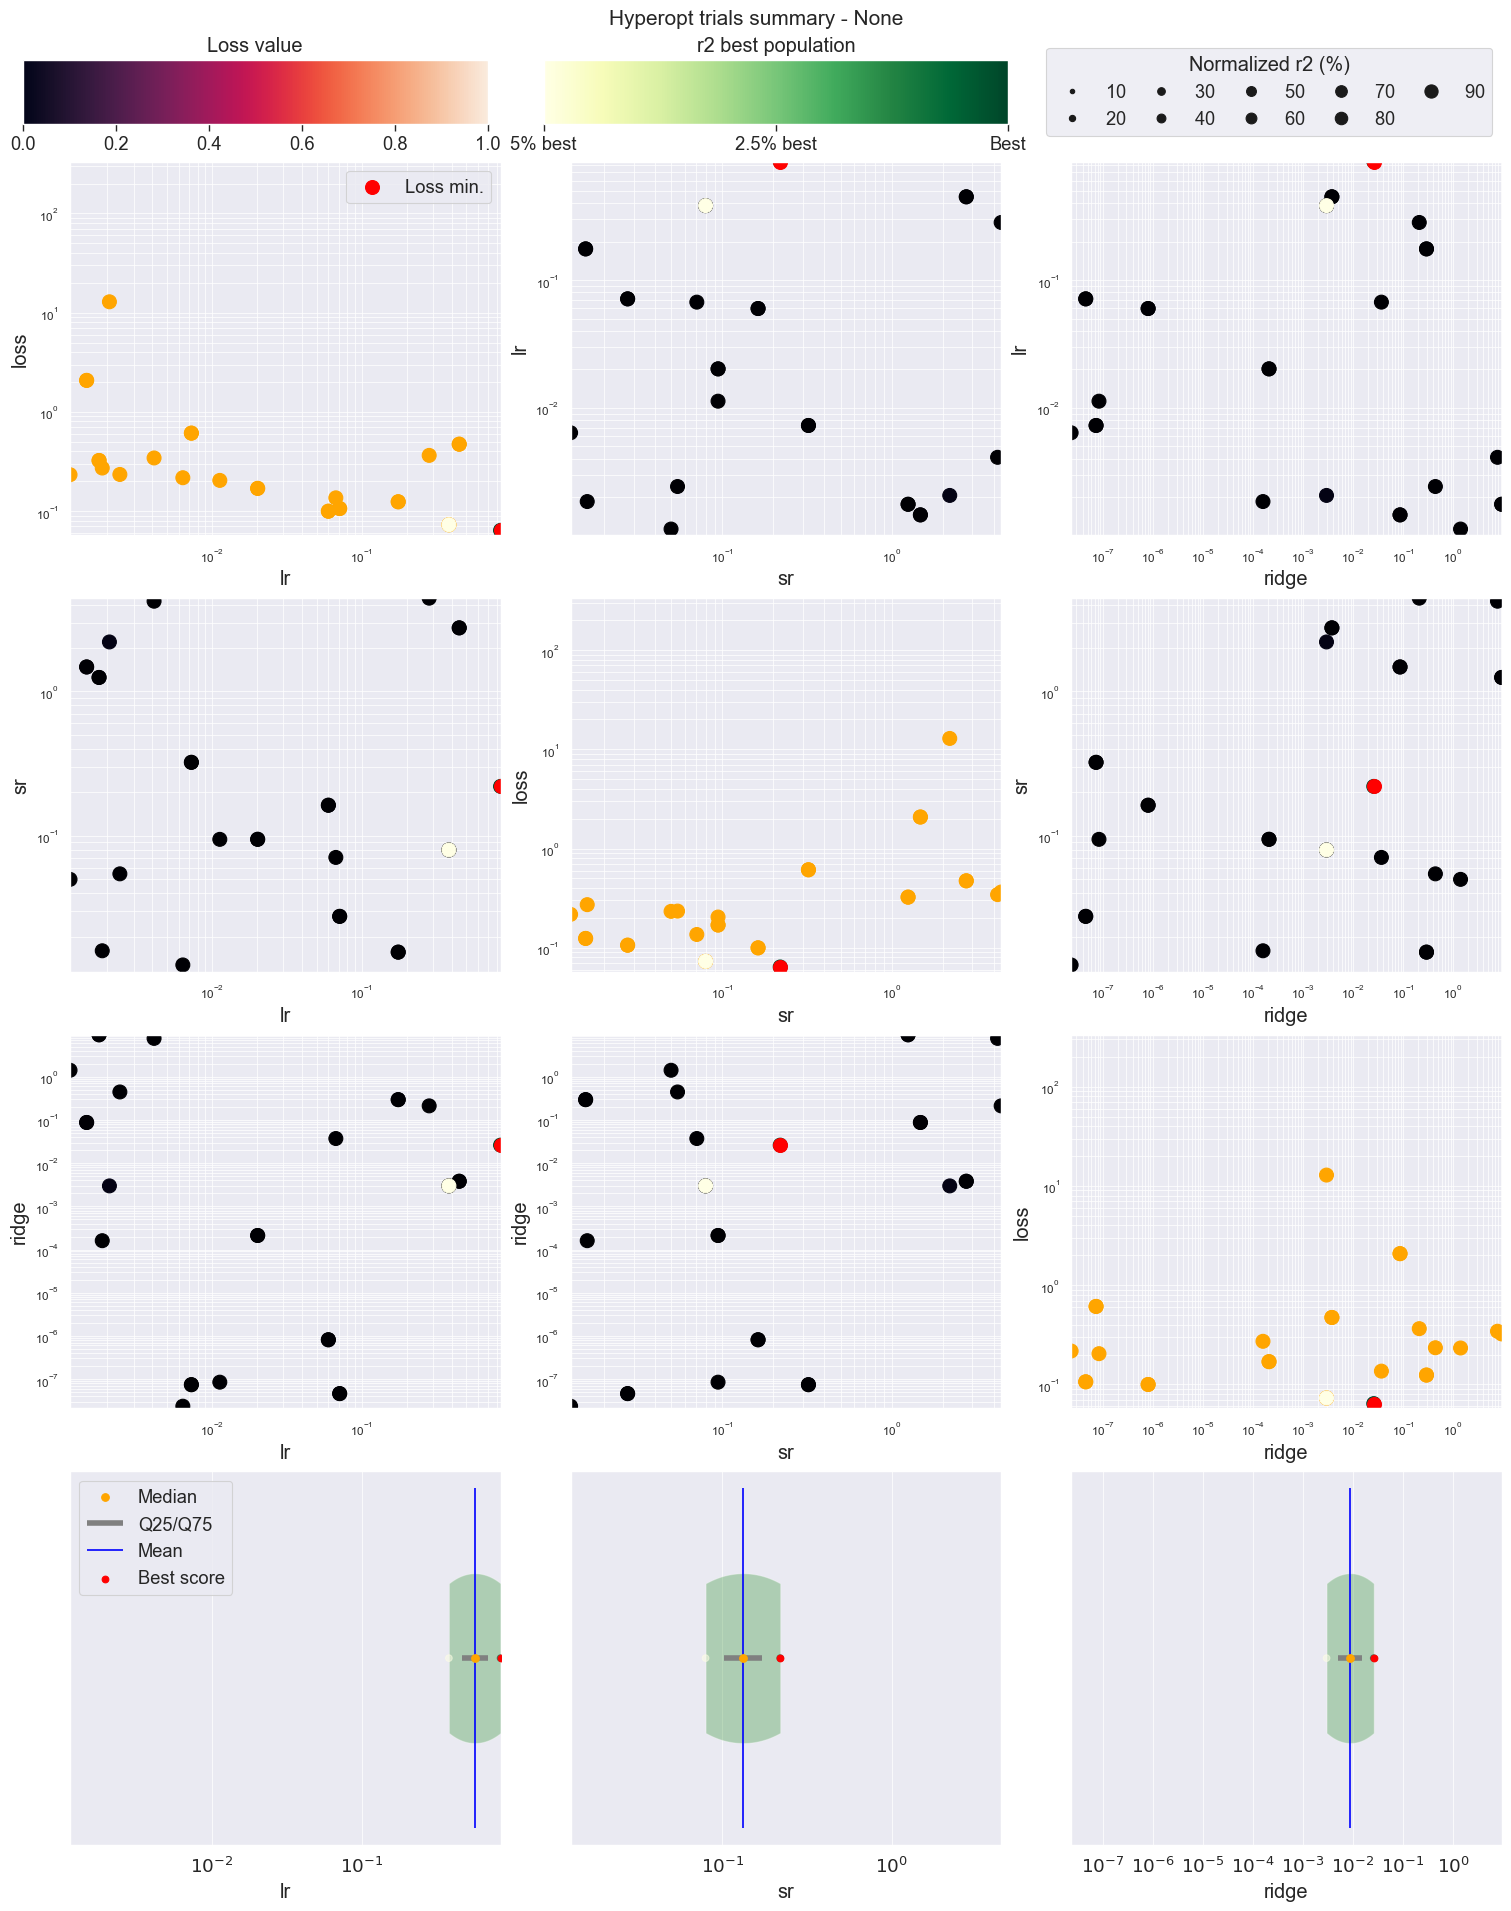

In [386]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")

## Task 2 : Use generative mode

- Train ESN on a one-timestep-ahead forecasting task.
- Run the ESN on its own predictions (closed loop generative mode)

In [666]:
units = 100
leak_rate = 0.3
spectral_radius = 0.99
input_scaling = 1.0
connectivity = 0.1      # - density of reservoir internal matrix
input_connectivity = 0.2  # and of reservoir input matrix
regularization = 1e-4
seed = 1234             # for reproducibility


In [667]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    #plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    #plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend()
    plt.show()

In [668]:
esn = reset_esn()

x, y = to_forecasting(X, forecast=1)
X_train3, y_train3 = x[:2000], y[:2000]
X_test3, y_test3 = x[2000:], y[2000:]

esn = esn.fit(X_train3, y_train3)

In [669]:
seed_timesteps = 150

warming_inputs = X_test3[:seed_timesteps]

warming_out = esn.run(warming_inputs, reset=True)  # warmup

In [670]:
nb_generations = 20

X_gen = np.zeros((nb_generations, 1))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = esn(y)
    X_gen[t, :] = y

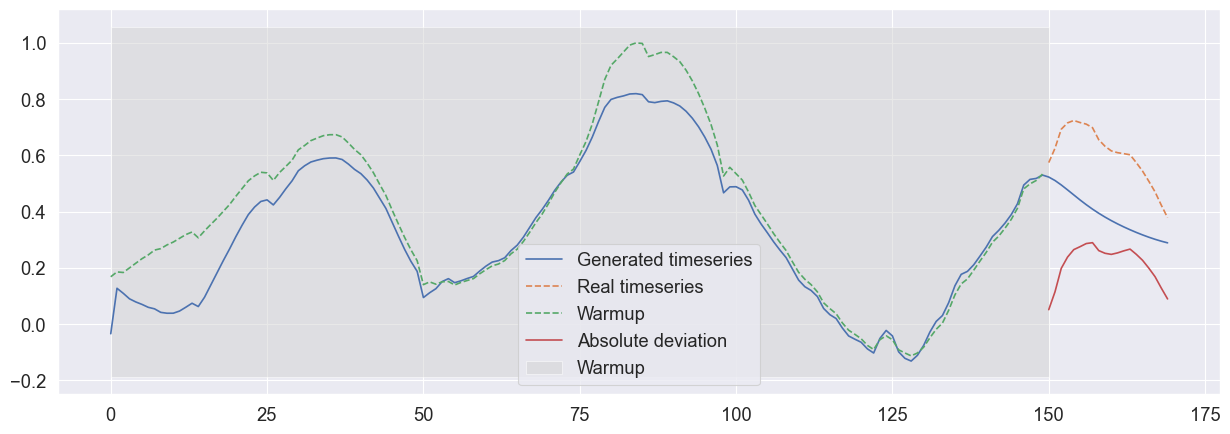

In [671]:
X_t = X_test3[seed_timesteps: nb_generations+seed_timesteps]
plot_generation(X_gen, X_t, nb_generations, warming_out=warming_out,
                warming_inputs=warming_inputs, seed_timesteps=seed_timesteps)

## Task 3 : Online learning

In [672]:
units = 100
leak_rate = 0.3
spectral_radius = 0.8#1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
seed = 1234

In [673]:
from reservoirpy.nodes import FORCE

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = FORCE(1)


esn_online = reservoir >> readout

Step by step training

In [674]:
outputs_pre = np.zeros(X_train1.shape)
for t, (x, y) in enumerate(zip(X_train1, y_train1)): # for each timestep of training data:
    outputs_pre[t, :] = esn_online.train(x, y)

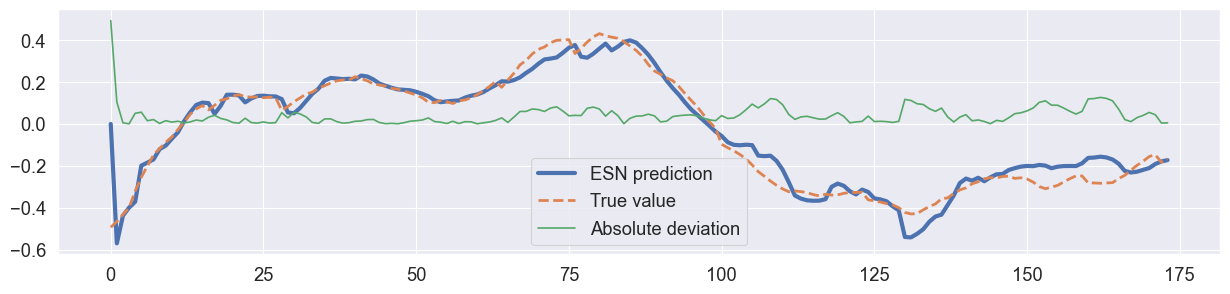

In [675]:
plot_results(outputs_pre, y_train1, sample=100)

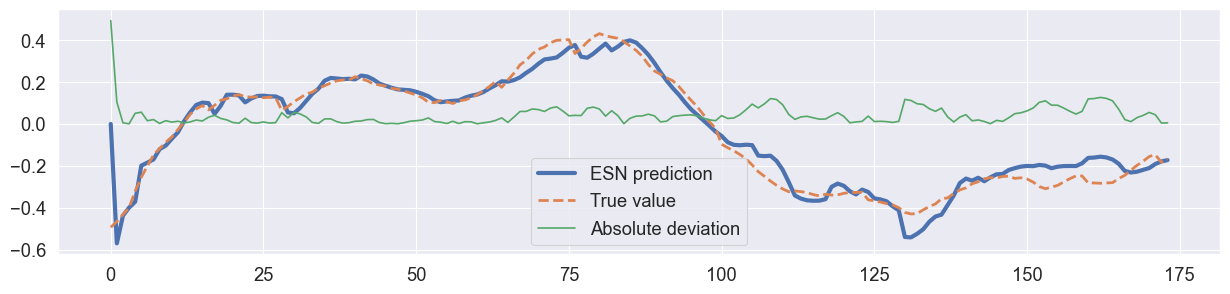

In [676]:
plot_results(outputs_pre, y_train1, sample=500)

Training on a whole timeseries

In [677]:
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = FORCE(1)


esn_online = reservoir >> readout

In [678]:
esn_online.train(X_train1, y_train1)

pred_online = esn_online.run(X_test1)  # Wout est maintenant figée

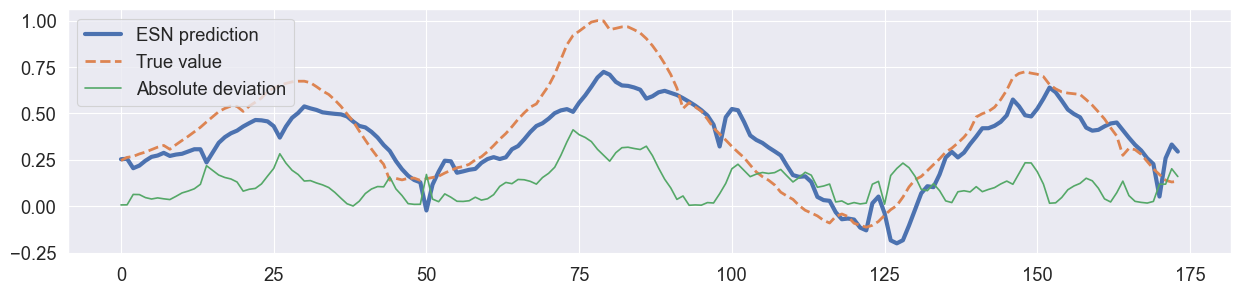

In [679]:
plot_results(pred_online, y_test1, sample=500)

# Simple Echo State Network using pytorch

In [680]:
import torch
from torch import nn
import matplotlib.pyplot as plt

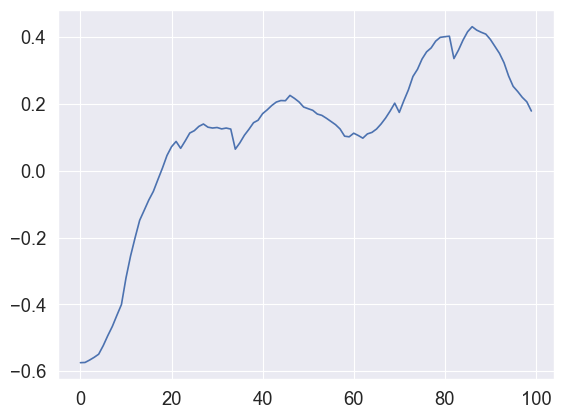

In [704]:
#X = torch.linspace(0, 1, len(uu))
#y = uu#torch.sin(6.0*X) + 0.05*torch.randn_like(X)
X = torch.linspace(0, 1, 100)
y = torch.from_numpy(uu[:100])#torch.sin(6.0*X) + 0.05*torch.randn_like(X)
_ = plt.plot(y)

In [714]:
y = y.to(torch.float32)


tensor([-0.5741, -0.5735, -0.5664, -0.5582, -0.5488, -0.5232, -0.4933, -0.4657,
        -0.4325, -0.4002, -0.3205, -0.2551, -0.2001, -0.1482, -0.1182, -0.0877,
        -0.0619, -0.0266,  0.0080,  0.0458,  0.0720,  0.0878,  0.0672,  0.0893,
         0.1129,  0.1200,  0.1328,  0.1399,  0.1304,  0.1279,  0.1295,  0.1253,
         0.1278,  0.1248,  0.0647,  0.0837,  0.1064,  0.1243,  0.1438,  0.1513,
         0.1710,  0.1823,  0.1953,  0.2056,  0.2101,  0.2097,  0.2255,  0.2165,
         0.2059,  0.1908,  0.1857,  0.1810,  0.1698,  0.1658,  0.1572,  0.1477,
         0.1381,  0.1250,  0.1035,  0.1016,  0.1124,  0.1055,  0.0976,  0.1103,
         0.1148,  0.1248,  0.1399,  0.1579,  0.1790,  0.2023,  0.1746,  0.2096,
         0.2420,  0.2821,  0.3036,  0.3343,  0.3559,  0.3676,  0.3880,  0.3992,
         0.4011,  0.4027,  0.3358,  0.3611,  0.3911,  0.4159,  0.4312,  0.4208,
         0.4143,  0.4089,  0.3930,  0.3722,  0.3513,  0.3232,  0.2837,  0.2527,
         0.2372,  0.2198,  0.2064,  0.17

In [715]:

class Reservoir(nn.Module):
  def __init__(self, hidden_dim, connectivity):
    super().__init__()
    
    self.Wx = self.sparse_matrix(hidden_dim, connectivity)
    self.Wh = self.sparse_matrix(hidden_dim, connectivity)
    self.Uh = self.sparse_matrix(hidden_dim, connectivity)
    self.act = nn.Tanh()

  def sparse_matrix(self, m, p):
    mask_distribution = torch.distributions.Bernoulli(p)
    S = torch.randn((m, m))
    mask = mask_distribution.sample(S.shape)
    S = (S*mask).to_sparse()
    return S

  def forward(self, x, h):
    h = self.act(torch.sparse.mm(self.Uh, h.T).T +
                 torch.sparse.mm(self.Wh, x.T).T)
    y = self.act(torch.sparse.mm(self.Wx, h.T).T)

    return y, h

In [716]:
class EchoState(nn.Module):
  def __init__(self, in_dim, out_dim, reservoir_dim, connectivity):
    super().__init__()

    self.reservoir_dim = reservoir_dim
    self.input_to_reservoir = nn.Linear(in_dim, reservoir_dim)
    self.input_to_reservoir.requires_grad_(False)

    self.reservoir = Reservoir(reservoir_dim, connectivity)
    self.readout = nn.Linear(reservoir_dim, out_dim)
  
  def forward(self, x):
    reservoir_in = self.input_to_reservoir(x)
    h = torch.ones(x.size(0), self.reservoir_dim)
    reservoirs = []
    for i in range(x.size(1)):
      out, h = self.reservoir(reservoir_in[:, i, :], h)
      reservoirs.append(out.unsqueeze(1))
    reservoirs = torch.cat(reservoirs, dim=1)
    outputs = self.readout(reservoirs)
    return outputs
     

In [723]:
model = EchoState(in_dim=1, out_dim=1, reservoir_dim=128, connectivity=0.05)
optimizer = torch.optim.Adam(model.readout.parameters(), lr=0.2)
loss_fn = nn.MSELoss()

In [724]:

epochs = 100
for epoch in range(epochs):
  optimizer.zero_grad()
  y_pred = model(X.view(1, -1, 1))
  loss = loss_fn(y_pred.squeeze(), y)
  loss.backward()
  optimizer.step()
  print(loss.item())

0.6458726525306702
158.0181427001953
10.358448028564453
35.66499710083008
90.2332534790039
63.458736419677734
14.93359088897705
1.5534089803695679
25.147233963012695
45.30517578125
37.54109191894531
14.618036270141602
0.6864198446273804
5.962449550628662
19.679515838623047
24.664094924926758
16.41960906982422
4.4949235916137695
0.17471499741077423
5.465019702911377
12.512856483459473
13.114365577697754
7.143143177032471
1.1196118593215942
0.558120846748352
4.589887619018555
7.7736287117004395
6.502872943878174
2.4898593425750732
0.06537297368049622
1.206315517425537
3.773364305496216
4.448564529418945
2.5691277980804443
0.42471256852149963
0.24154341220855713
1.6952390670776367
2.6649606227874756
1.954643964767456
0.5336992144584656
0.05665474757552147
0.8030959367752075
1.5538667440414429
1.294822096824646
0.4198758006095886
0.02444560080766678
0.4392671585083008
0.9338553547859192
0.8023700714111328
0.2578836679458618
0.01442667841911316
0.2857488989830017
0.5841227173805237
0.470474

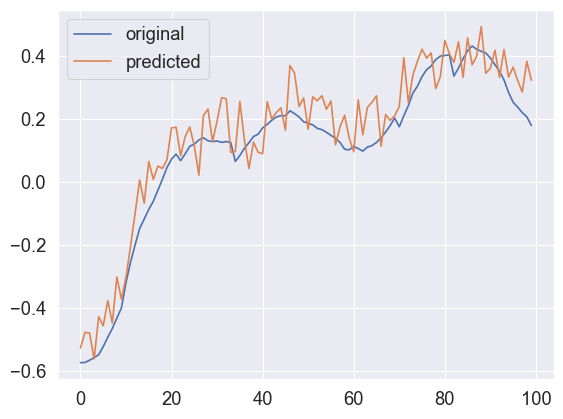

In [725]:
with torch.no_grad():
  y_pred = model(X.view(1, -1, 1)).squeeze()

plt.plot(y, label='original')
plt.plot(y_pred.detach().numpy(), label='predicted')
plt.legend()
_ = plt.show()

### pyENS

In [732]:
import numpy as np


def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.

    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s

    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.

        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states

        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

In [735]:
data = uu.astype('float64')
data

array([-0.57411003, -0.5735142 , -0.56636557, ...,  0.12700206,
        0.15673571,  0.15138351])

In [748]:
n_reservoir= 500
sparsity=0.02#0.2
rand_seed=23
spectral_radius = 1
noise = .0005


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

trainlen = 1500
future = 10
futureTotal=100
pred_tot=np.zeros(futureTotal)

for i in range(0,futureTotal,future):
    pred_training = esn.fit(np.ones(trainlen),data[i:trainlen+i])
    prediction = esn.predict(np.ones(future))
    pred_tot[i:i+future] = prediction[:,0]

In [737]:
import seaborn as sns
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

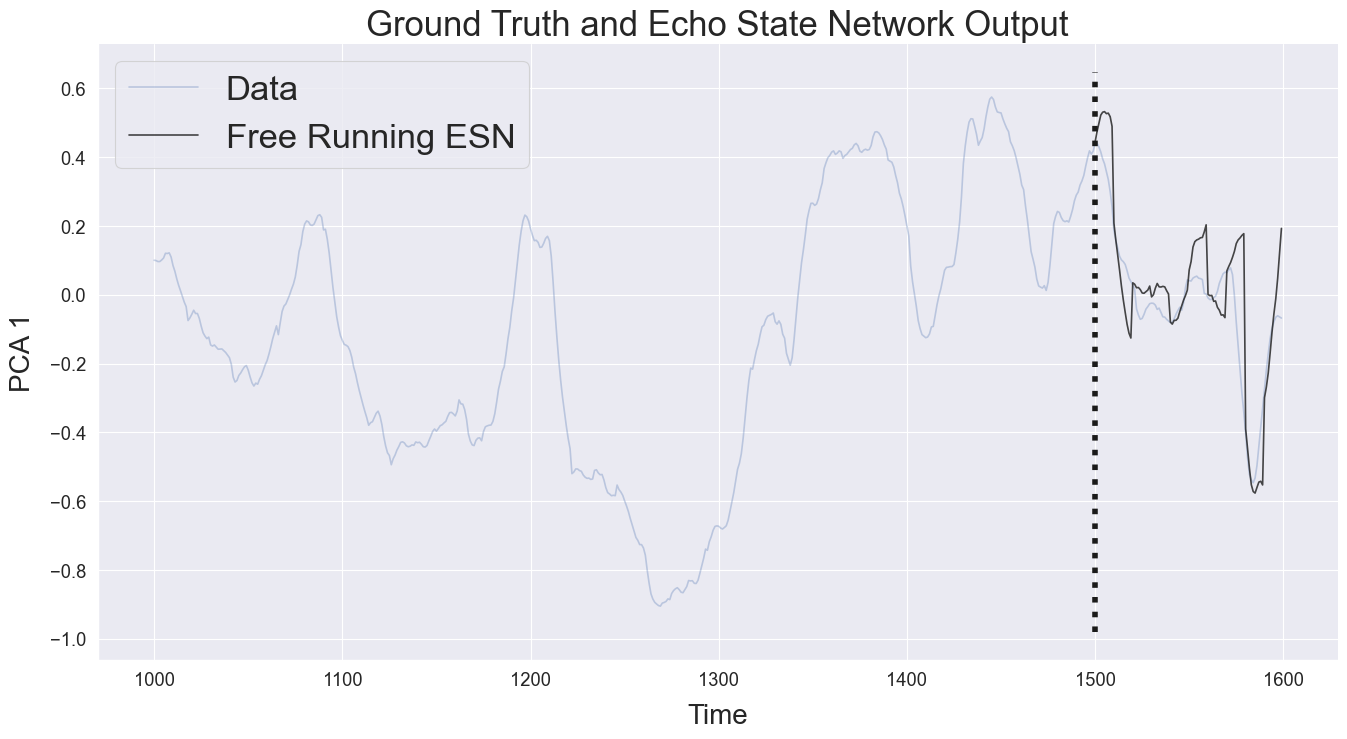

In [749]:
plt.figure(figsize=(16,8))
plt.plot(range(1000,trainlen+futureTotal),data[1000:trainlen+futureTotal],'b',label="Data", alpha=0.3)
#plt.plot(range(0,trainlen),pred_training,'.g',  alpha=0.3)
plt.plot(range(trainlen,trainlen+futureTotal),pred_tot,'k',  alpha=0.8, label='Free Running ESN')

lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

plt.title(r'Ground Truth and Echo State Network Output', fontsize=25)
plt.xlabel(r'Time', fontsize=20,labelpad=10)
plt.ylabel(r'PCA 1', fontsize=20,labelpad=10)
plt.legend(fontsize='xx-large', loc='best')
sns.despine()

In [739]:
def MSE(yhat, y):
    return np.sqrt(np.mean((yhat.flatten() - y)**2))

In [742]:
n_reservoir= 500
sparsity   = 0.2
rand_seed  = 23


radius_set = [0.5,1,  1.5]
noise_set = [ 0.0001, 0.001,0.01]



radius_set_size  = len(radius_set)
noise_set_size = len(noise_set)

trainlen = 1500
future = 2
futureTotal= 100

loss = np.zeros([radius_set_size, noise_set_size])

for l in range(radius_set_size):
    rho = radius_set[l]
    for j in range(noise_set_size):
        noise = noise_set[j]

        pred_tot=np.zeros(futureTotal)

        esn = ESN(n_inputs = 1,
          n_outputs = 1, 
          n_reservoir = n_reservoir,
          sparsity=sparsity,
          random_state=rand_seed,
          spectral_radius = rho,
          noise=noise)

        for i in range(0,futureTotal,future):
            pred_training = esn.fit(np.ones(trainlen),data[i:trainlen+i])
            prediction = esn.predict(np.ones(future))
            pred_tot[i:i+future] = prediction[:,0]
        
        loss[l, j] = MSE(pred_tot, data[trainlen:trainlen+futureTotal])        
        print('rho = ', radius_set[l], ', noise = ', noise_set[j], ', MSE = ', loss[l][j] )

rho =  0.5 , noise =  0.0001 , MSE =  0.027318063570724093
rho =  0.5 , noise =  0.001 , MSE =  0.02820503893762125
rho =  0.5 , noise =  0.01 , MSE =  0.028440051702675533
rho =  1 , noise =  0.0001 , MSE =  0.028494090190731198
rho =  1 , noise =  0.001 , MSE =  0.02729156811855308
rho =  1 , noise =  0.01 , MSE =  0.027251963536820585
rho =  1.5 , noise =  0.0001 , MSE =  0.03806038134175857
rho =  1.5 , noise =  0.001 , MSE =  0.03825387395164474
rho =  1.5 , noise =  0.01 , MSE =  0.03142894472190229


In [743]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
rho_opt = radius_set[int(index_min[0])]
noise_opt = noise_set[int(index_min[1])]
print('The optimal set is:\nspectrum radius = ',
      rho_opt,'\nnoise = ',noise_opt,'\nMSE = ',minLoss)

The optimal set is:
spectrum radius =  1 
noise =  0.01 
MSE =  0.027251963536820585
